In [6]:
import pandas as pd

# -*- coding: utf-8 -*-
"""
@name: Week 3 Poisson GLM.py
@author: Ming-Long Lam, Ph.D.
@organization: University of Chicago
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sys
# Set some options for printing all the columns
np.set_printoptions(precision = 10, threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)
pandas.options.display.float_format = '{:,.10}'.format
import seaborn as sns
import math
from scipy.stats import chi2

sys.path.append('C:\\MScAnalytics\\Linear and Nonlinear Model\\Job')
import Regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [7]:
target = 'CLM_COUNT'
exposure = 'EXPOSURE'
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED","URBANICITY",'HOMEKIDS', 'KIDSDRIV',"AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF","TRAVTIME"]
cat_cols = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED", "URBANICITY"]
claim_history = pandas.read_excel('claim_history.xlsx')
claim_history[["BLUEBOOK","HOME_VAL","INCOME"]] = claim_history[["BLUEBOOK","HOME_VAL","INCOME"]]/1000
 # Only positive

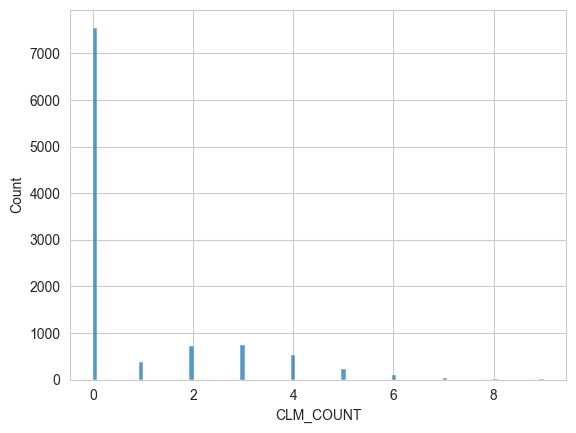

In [8]:
q1a = sns.histplot(claim_history["CLM_COUNT"])

In [9]:
claim_history.shape[0]

10302

In [10]:
train_data = claim_history[claim_history['EXPOSURE'] > 0.0]
train_data = train_data[[target] + [exposure] + int_pred]   # Only necessary
train_data = train_data.dropna().reset_index()              # Remove missing values
# Missing value situation
train_data.shape[0]

5715

NameError: name 'numpy' is not defined

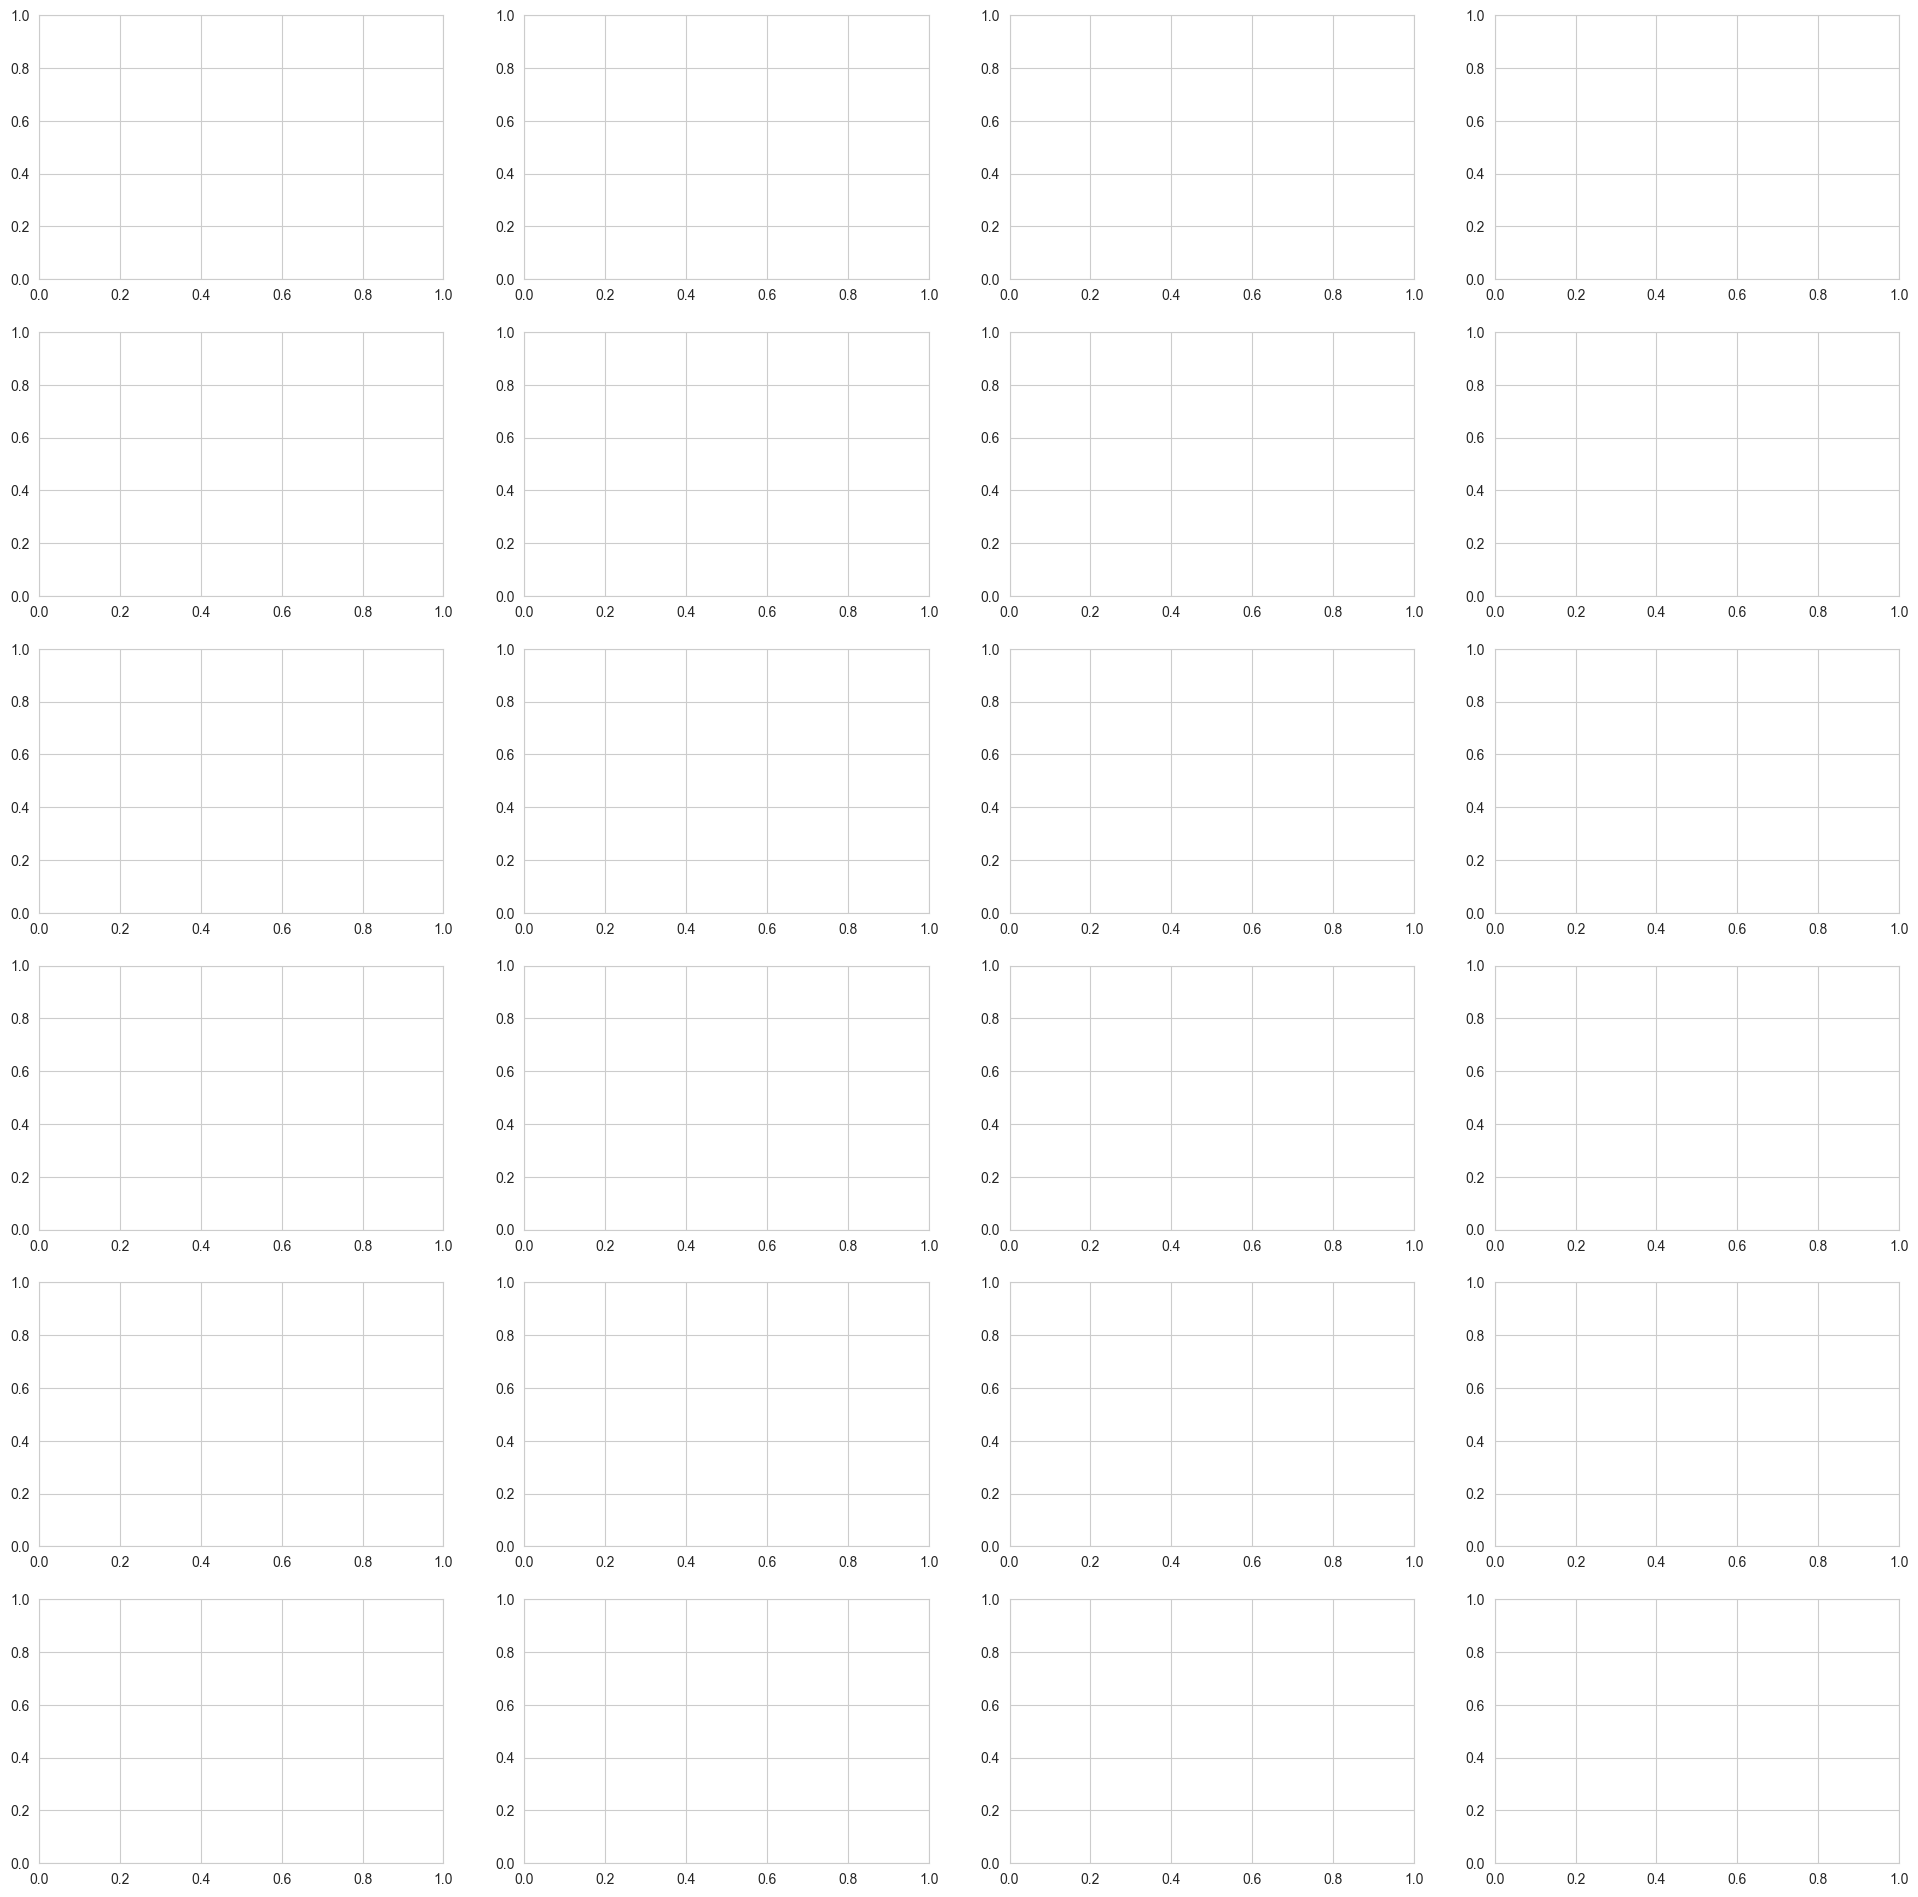

In [11]:
# # Display relationship in heatmap
# n_col = 4
# n_rows = round(len(int_pred)/n_col) + 1
# fig,axs = plt.subplots(nrows=n_rows,ncols=n_col,figsize=(24,24))
# counter = 0
# row_counter = 0
# # print(n_rows,n_col)
# for pred in int_pred:
#     # print(row_counter,counter)
#     xtab = pandas.crosstab(train_data[target], train_data[pred], values = train_data[exposure], aggfunc=numpy.mean)
#     xtab.fillna(0, inplace = True)
#     plt.figure(figsize = (10,8), dpi = 200)
#     ax = sns.heatmap(xtab, cmap = 'PiYG', cbar_kws = {'label': 'MeanExposure'},
#     ax = axs[row_counter][counter])
#     # ax.invert_yaxis()
#     counter+=1
#     if counter == 4:
#         row_counter+=1
#         counter = 0

In [13]:
n_sample = train_data.shape[0]
y_train = train_data[target]
o_train = np.log(train_data[exposure])
# Build a model with only the Intercept term
X_train = train_data[[target]]
X_train.insert(0, 'Intercept', 1.0)
X_train = X_train.drop(columns = target)
result = Regression.PoissonRegression (X_train, y_train, o_train)
outCoefficient = result[0]
outCovb = result[1]
outCorb = result[2]
llk = result[3]
nonAliasParam = result[4]
outIterationTable = result[5]
y_pred = result[6]
aic = -2*llk + 2*len(nonAliasParam)
bic = -2*llk + len(nonAliasParam)*math.log(n_sample)
print(llk,aic,bic)

-9202.190712554877 18406.381425109754 18413.032274685982


In [14]:
train_data.shape[0]

5715

In [15]:
def create_categorical_value(df,column_name):
    u = df[column_name].astype('category')
    u_freq = u.value_counts(ascending = True)
    pm = u.cat.reorder_categories(list(u_freq.index))
    term_df_type = pandas.get_dummies(pm)
    return term_df_type

In [16]:
def run_against_all(df,init_cols,categorical_cols,previous_train,output_train,exposure_train,ll,dv):
    step_detail = []
    Regression_Output = None
    output_list = []
    for i in init_cols:
        if i in categorical_cols:
            new_train = previous_train.join(create_categorical_value(df,i),rsuffix = i)
        else:
            new_train = previous_train.join(df[i],rsuffix = i)
        Regression_Output = Regression.PoissonRegression(new_train, output_train, exposure_train)
        ll_1 = Regression_Output[3]
        dv_1 = len(Regression_Output[4])
        deviance_chisq = 2 * (ll_1 - ll)
        deviance_df = dv_1 - dv
        deviance_sig = chi2.sf(deviance_chisq, deviance_df)
        step_detail.append([str(i), dv_1, ll_1, deviance_chisq, deviance_df,deviance_sig])
        output_list.append(Regression_Output)
    step_df = pd.DataFrame(step_detail)
    chosen_value = step_df[step_df[5] == step_df[5].min()]
    chosen_output = output_list[step_df.index[step_df[5] == step_df[5].min()].tolist()[0]]
    return chosen_value.values, chosen_output

In [86]:
def forward_selector(data,target_col,exposure_col,init_cols,cat_columns):
    #First Run
    target_train = data[target_col]
    exposure_train = np.log(data[exposure_col])
    intercept_train = data[[target_col]]
    init = init_cols
    intercept_train.insert(0, 'Intercept', 1.0)
    intercept_train = intercept_train.drop(columns = target_col)
    intercept_result = Regression.PoissonRegression (X_train, y_train, o_train)
    step_summary = []
    ll = result[3]
    dv = len(result[4])
    deviance_sig = 0
    threshold = 0.01
    value_outputs = None
    step_summary.append(['Intercept', dv, ll, np.nan, np.nan, np.nan])
    while (deviance_sig < threshold):
        run,s = run_against_all(data,init,cat_columns,intercept_train,target_train,exposure_train,ll,dv)
        run = run[0]
        ll = run[2]
        dv= run[1]
        deviance_sig = run[5]
        if(deviance_sig<threshold):
            value_outputs = s
            if run[0] in cat_columns:
                intercept_train = intercept_train.join(create_categorical_value(data,run[0]),rsuffix=str(run[0]))
            else:
                intercept_train = intercept_train.join(data[run[0]],rsuffix=str(run[0]))
            init.remove(run[0])
            # print([ll,dv,deviance_sig,counter])
            step_summary.append([run[0], dv, ll, run[3], run[4], run[5]])
    # print(intercept_train)
    step_summary = pd.DataFrame(step_summary)
    return step_summary, value_outputs,intercept_train

In [87]:
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED","URBANICITY",'HOMEKIDS', 'KIDSDRIV',"AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF","TRAVTIME"]
df,outps,train = forward_selector(train_data,target,exposure,int_pred,cat_cols)

In [22]:
df

,0,1,2,3,4,5
0,Intercept,1,"-9,202.190713",NaN,NaN,NaN
1,URBANICITY,2,"-8,796.722613",810.9361989,1.0,2.261281474e-178
2,EDUCATION,6,"-8,488.805338",615.8345498,4.0,5.795205239e-132
3,MVR_PTS,7,"-8,349.865822",277.8790324,1.0,2.176696531e-62
4,CAR_TYPE,12,"-8,234.98562",229.7604031,5.0,1.203793916e-47
5,TRAVTIME,13,"-8,163.342263",143.2867143,1.0,5.087947595e-33
6,CAR_USE,14,"-8,097.875925",130.9326765,1.0,2.561478545e-30
7,KIDSDRIV,15,"-8,049.321029",97.10979118,1.0,6.558776082e-23
8,INCOME,16,"-8,000.010438",98.62118359,1.0,3.057312231e-23
9,REVOKED,17,"-7,958.349167",83.32254054,1.0,6.970030159e-20


In [27]:
aic = -2*outps[3] + 2*len(outps[4])
bic = -2*outps[3] + len(outps[4])*math.log(n_sample)
print(aic,bic)

15752.737727294352 15899.056417971387


In [25]:
def distance_corr (x,y):
    #Calculate the Adjusted Distance for x
    x_new = pd.DataFrame(x)
    y_new = pd.DataFrame(y)
    x_new = x_new.dropna()
    y_new = y_new.dropna()
    x_new = x_new.fillna(0)
    i = x_new.to_numpy().T[0]
    n = len(i)
    distance_matrix_x = pd.DataFrame(np.abs(i[:, None] - i))
    distance_matrix_x = distance_matrix_x.sub(distance_matrix_x.mean(axis=0),axis=1)
    distance_matrix_x = distance_matrix_x.sub(distance_matrix_x.mean(axis=1),axis=0)
    emp_dist_x = distance_matrix_x.pow(2)
    emp_dist_x = emp_dist_x.values.sum()/(n**2)
    #Calculate the Adjusted Distance for y
    y_new = y_new.fillna(0)
    d = y_new.to_numpy().T[0]
    n = len(i)
    distance_matrix_y = pd.DataFrame(np.abs(d[:, None] - d))
    distance_matrix_y = distance_matrix_y.sub(distance_matrix_y.mean(axis=0),axis=1)
    distance_matrix_y = distance_matrix_y.sub(distance_matrix_y.mean(axis=1),axis=0)
    emp_dist_y = distance_matrix_y.pow(2)
    emp_dist_y = emp_dist_y.values.sum()/(n**2)
    #Calculate the Distance covariance
    emp_dist_xy = distance_matrix_x.mul(distance_matrix_y,axis="index")
    emp_dist_xy = emp_dist_xy.values.sum()/(n**2)
    #Calculate the Distance Correlation Coefficient
    distance_correlation_coeff = math.sqrt((emp_dist_xy)/(math.sqrt(emp_dist_x*emp_dist_y)))
    return round(distance_correlation_coeff,4)


In [109]:
result[6]

0      0.7682278185
1      0.6360926337
2      0.7682278185
3      0.7682278185
4      0.7682278185
           ...     
5710   0.7682278185
5711   0.7682278185
5712   0.7682278185
5713   0.7682278185
5714   0.7682278185
Name: EXPOSURE, Length: 5715, dtype: float64

In [118]:
def find_metrics(y_true,y_pred):
    rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    observed_mean = np.mean(y_true)
    predicted_mean = np.mean(y_pred)
    rel_error = np.sum((y_true-y_pred)**2)/np.sum((y_true-observed_mean)**2)
    dist_corr = distance_corr(y_true,y_pred)
    # r_sq = r2_score(y_true,y_pred)
    r_sq = np.sum(((y_pred-predicted_mean)*(y_true-observed_mean))**2)/(np.sum((y_pred-predicted_mean)**2)*np.sum((y_true-observed_mean)**2))
    y_df = pd.DataFrame(y_true,columns=["Y_True"])
    y_df["Y_Train"] = y_pred
    pearson_corr = y_df[["Y_True","Y_Train"]].corr(method="pearson")
    return([rmse,rel_error,dist_corr,r_sq,pearson_corr.iloc[0][1]])

In [119]:
find_metrics(train_data[target].values,result[6])

[1.4635157608954519,
 1.0759932377155375,
 0.2297,
 0.0002376497751982263,
 -0.1913830978328355]

In [120]:
find_metrics(train_data[target].values,outps[6])

[1.394622473342235,
 0.9770753409646038,
 0.2806,
 0.000278486288014503,
 0.26148738692859386]

In [105]:
pred_y = outps[6]
true_y = train_data[target].values

In [156]:
y_pred

0       0.8197863032
1       0.8900198377
2      0.03350515344
3        1.208588893
4         2.13295234
            ...     
5710    0.2060343482
5711    0.5237138031
5712    0.6408006689
5713    0.2715228615
5714    0.0819351836
Name: EXPOSURE, Length: 5715, dtype: float64

In [174]:
pearson_chi_statistic = np.sum((true_y-pred_y)**2/pred_y)
dof = n_sample-len(outps[4])
print(pearson_chi_statistic,dof)

54445.80441439693 5693


In [170]:
di = -((true_y*np.log(pred_y/true_y))+(true_y-pred_y))
dR2 = np.where(true_y > 0.0, di, 0)
devResid = np.where(true_y > pred_y, 1.0, -1.0) * np.where(dR2 > 0.0, np.sqrt(2.0 * dR2), 0.0)
deviance_chisq = 2*np.sum(dR2)

In [175]:
print(deviance_chisq)

7047.060486578081


In [171]:
pearson_sig = chi2.sf(pearson_chi_statistic, dof)
deviance_sig = chi2.sf(deviance_chisq, dof)
print(pearson_sig,deviance_sig)

0.0 1.736819980345942e-32


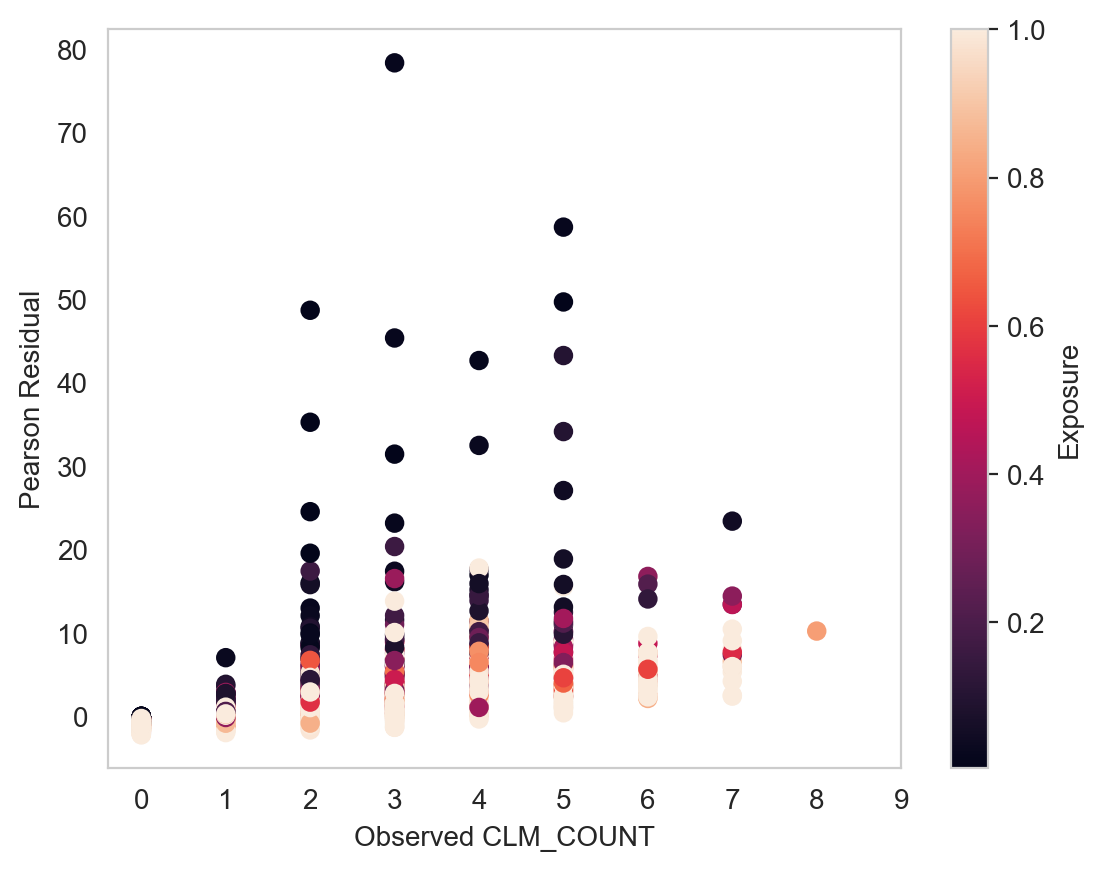

In [129]:
y_resid = true_y - pred_y
pearsonResid = np.where(pred_y > 0.0, y_resid / np.sqrt(pred_y), np.NaN)
plt.figure(dpi = 200)
sg = plt.scatter(true_y, pearsonResid, c = train_data[exposure], marker = 'o')
plt.xlabel('Observed CLM_COUNT')
plt.ylabel('Pearson Residual')
plt.xticks(range(10))
plt.grid(axis = 'both')
plt.colorbar(sg, label = 'Exposure')
plt.show()

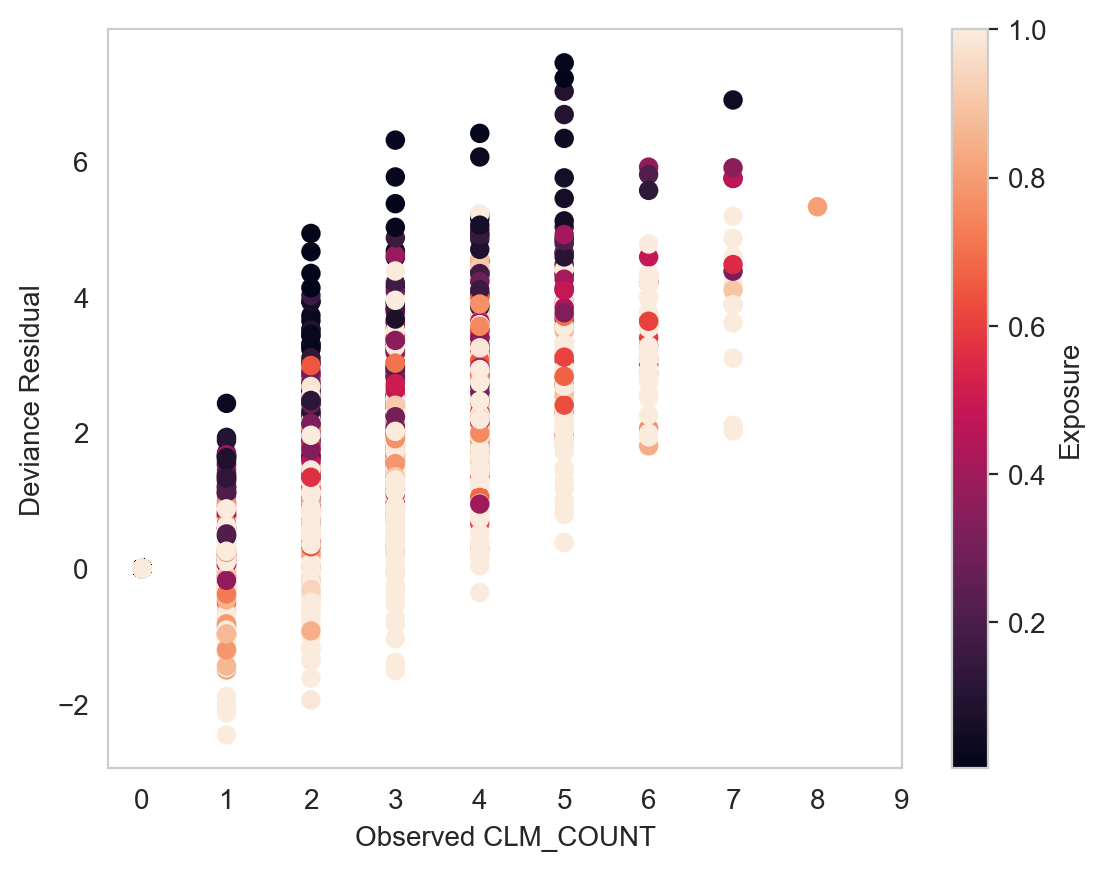

In [173]:
plt.figure(dpi = 200)
sg = plt.scatter(true_y, devResid, c = train_data[exposure], marker = 'o')
plt.xlabel('Observed CLM_COUNT')
plt.ylabel('Deviance Residual')
plt.xticks(range(10))
plt.grid(axis = 'both')
plt.colorbar(sg, label = 'Exposure')
plt.show()